### Fitting HB data with three lines

###### written by Nicola Pastorello 29/10/2015

In [1]:
%matplotlib inline
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc, optimize

In [2]:
# Functions
def functLinesStep(inputPars, xr, numberLines): #Function with sequential lines (not contiguous)
    mvalues, qvalues, breakPoints = (inputPars[:numberLines], 
                                     inputPars[numberLines:numberLines+3], 
                                     inputPars[-numberLines+1:])
    #
    if (len(mvalues)!=numberLines) or (len(qvalues)!=numberLines):
        print "Number of parameters not matching"
        return False
    #
    # Select different regions
    regions = retrieveSelection(xr, breakPoints)
    #
    yy = np.empty(len(xr))
    for ii in np.arange(len(regions)):
        selection = regions[ii][0]
        yy[selection] = mvalues[ii]*xr[selection]+qvalues[ii]
    return yy
# Example
# xx = np.arange(1400)
# yy = functLinesStep(xx, [0, 0.5, -0.2, 0.1], [1,2,5.,-2], [250, 800, 1200])
# plot(xx,yy)

def measure_chi2_Lines(inputPars, xx, yy, numberLines):
    yy_model = functLinesStep(inputPars, xx, numberLines)
    chi2 = Chi2(yy, yy_model)
    return chi2

def Chi2(values, model, errors=nan):
    if not(errors):
        errors = np.ones(len(values))
    sel = np.nonzero(model)
    return np.sum((values[sel]-model[sel])**2./abs(model[sel]))


def retrieveSelection(xx, breaks):
    selections = []
    selections.append(np.where(xx<breaks[0]))
    for ii in np.arange(len(breaks)-1):
        selections.append(np.where((xx>=breaks[ii]) & (xx<breaks[ii+1])))
    selections.append(np.where(xx>breaks[-1]))
    return selections

In [3]:
# Retrieve data
fileIn = open('dicDF.dat', 'rb')
dicDF = pickle.load(fileIn)
fileIn.close()

#### Fit of the profile with the multiple-lines approach

In [4]:
counter = 0
dicSolution = {}
for dicKey in dicDF.keys():
    counter += 1; print counter, '/', len(dicDF.keys())
    DFtmp = dicDF[dicKey]
    
    # Initial guesses

    xx, yy = np.array(DFtmp.index), np.array(DFtmp['hb'])
    guessNightTime = [660, 1080] # Minutes of sleeping time (11pm-6am)
    # This can be found more efficiently somehow else (e.g. rolling 
    # Gini coefficient, accelerometer std, ...)

    [sel_1, sel_2, sel_3] = retrieveSelection(xx, guessNightTime)

    values_line_1 = np.polyfit(xx[sel_1], yy[sel_1], 1)
    values_line_2 = np.polyfit(xx[sel_2], yy[sel_2], 1)
    values_line_3 = np.polyfit(xx[sel_3], yy[sel_3], 1)


    initialGuesses = ([values_line_1[0], values_line_2[0], values_line_3[0],  #m
                   values_line_1[1], values_line_2[1], values_line_3[1], #q
                   guessNightTime[0], guessNightTime[1]]) #breaks
    numberLines = 3
    
    # Pearson's Chi^2 minimization with Nelder-Mead algorithm

    solution = optimize.minimize(measure_chi2_Lines, 
                                initialGuesses,
                                args=(xx,yy, numberLines), 
                                method='Nelder-Mead', 
                                options={'disp':True, 
                                         'maxiter':1e5, 'maxfev':1e5})
    dicSolution[dicKey] = solution


1 / 208
Optimization terminated successfully.
         Current function value: 633.098564
         Iterations: 1076
         Function evaluations: 1665
2 / 208
Optimization terminated successfully.
         Current function value: 1760.019643
         Iterations: 1358
         Function evaluations: 2101
3 / 208
Optimization terminated successfully.
         Current function value: 1321.822531
         Iterations: 1413
         Function evaluations: 2164
4 / 208
Optimization terminated successfully.
         Current function value: 980.090446
         Iterations: 1781
         Function evaluations: 2707
5 / 208
Optimization terminated successfully.
         Current function value: 1937.610641
         Iterations: 1314
         Function evaluations: 2083
6 / 208
Optimization terminated successfully.
         Current function value: 601.938248
         Iterations: 1010
         Function evaluations: 1575
7 / 208
Optimization terminated successfully.
         Current function value: 797.07

In [5]:
# Creating plots

if not(os.path.exists('Plots')):
    os.mkdir('Plots')

for ii in dicSolution.keys():
    pathOut = 'Plots/'+ii[13:-3]+'pdf'
    DFtmp = dicDF[ii]
    plt.ioff()
    fig = figure(num=0, figsize=(6,5))
    clf()
    
    DFtmp.plot()

    plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='m', label='Guess')
    plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='m')
    plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='m')

    solution = dicSolution[ii] # Minimization solution

    [sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
    plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='k', label='Best fit')
    plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='k')
    plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')
    legend(loc=3)
    ylabel('HB/min'); xlabel('min'); title(r'$\chi^{2}=$'+str(round(solution.fun,2)))
    savefig(pathOut, bbox_inches='tight')

/Users/nicola/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [ ]:
# Creating histograms
slope_2 = []
sleepingtime = []
awakingtime = []
for ii in dicSolution.keys():
    slope_2.append(dicSolution[ii].x[1])
    sleepingtime.append(dicSolution[ii].x[6])
    awakingtime.append(dicSolution[ii].x[7])


# Plot
figure(0)
hh = hist(slope_2, 50)
xlabel('Slope'); ylabel('N')

figure(num=1, figsize=(12,5))
ax1, ax2 = subplot(121), subplot(122)
hh_sleep = ax1.hist(sleepingtime, 50); ax1.set_xlabel('Sleeping time'); ax1.set_ylabel('N')
hh_awake = ax2.hist(awakingtime, 50); ax2.set_xlabel('Awakening time'); ax2.set_ylabel('N')



# SAVE Slopes as pandas DF -> csv

seriesSleepTime_fit = pd.Series(sleepingtime)
seriesAwakeTime_fit = pd.Series(awakingtime)
seriesSlope_fit = pd.Series(slope_2)
seriesID = pd.Series(dicSolution.keys())

dic_fit = {'ID':seriesID, 'Slope': seriesSlope_fit, 
           'SleepTime': seriesSleepTime_fit, 'AwakeTime': seriesAwakeTime_fit}

df_fit = pd.DataFrame(dic_fit)    
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Save series of slopes as .csv
write_csv(dicSlope,'Fit.csv')

#### Example of issue with sleeping/awakening time

Optimization terminated successfully.
         Current function value: 538.699913
         Iterations: 2420
         Function evaluations: 3752


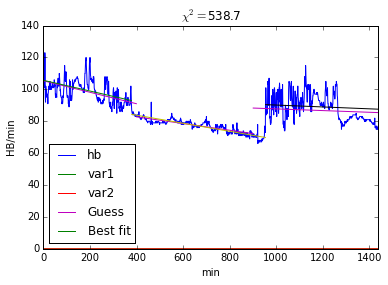

In [219]:
DFtmp = dicDF['Fileset0_csv/KH2.csv']
   
    # Initial guesses
xx, yy = np.array(DFtmp.index), np.array(DFtmp['hb'])
guessNightTime = [400, 900] 

#guessNightTime = [660, 1080]# Minutes of sleeping time (11pm-6am)
# This can be found more efficiently somehow else (e.g. rolling 
# Gini coefficient, accelerometer std, ...)

[sel_1, sel_2, sel_3] = retrieveSelection(xx, guessNightTime)

values_line_1 = np.polyfit(xx[sel_1], yy[sel_1], 1)
values_line_2 = np.polyfit(xx[sel_2], yy[sel_2], 1)
values_line_3 = np.polyfit(xx[sel_3], yy[sel_3], 1)


initialGuesses = ([values_line_1[0], values_line_2[0], values_line_3[0],  #m
                   values_line_1[1], values_line_2[1], values_line_3[1], #q
                   guessNightTime[0], guessNightTime[1]]) #breaks
numberLines = 3
    
    # Pearson's Chi^2 minimization with Nelder-Mead algorithm

solution = optimize.minimize(measure_chi2_Lines, 
                                initialGuesses,
                                args=(xx,yy, numberLines), 
                                method='Nelder-Mead', 
                                options={'disp':True, 
                                         'maxiter':1e5, 'maxfev':1e5, 
                                        'xtol':1e-9})

plt.ion()
figure(1)
plt.clf()
DFtmp.plot()
plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='m', label='Guess')
plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='m')
plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='m')

[sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='g', label='Best fit')
plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='y')
plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')
legend(loc=3)
ylabel('HB/min'); xlabel('min'); title(r'$\chi^{2}=$'+str(round(solution.fun,2)))
     

### TESTING

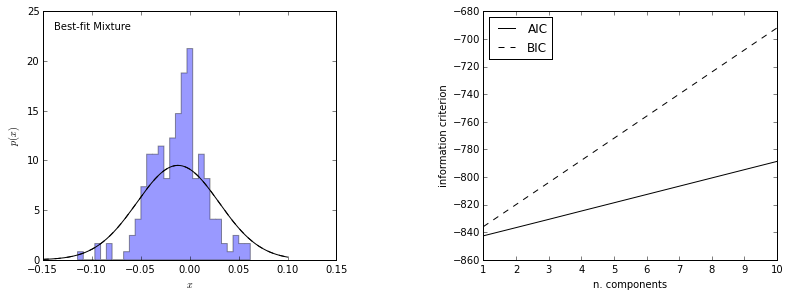

In [213]:
# Fitting slope histogram with Gaussian mixture model
from sklearn import mixture
from sklearn.mixture import GMM
np.random.seed(1)

X = np.array(slope_2)
X = X.reshape(-1, 1)

# fit models with 1-10 components
N = np.arange(1,11)
models = [None for ii in range(len(N))]

for ii in range(len(N)):
    models[ii] = mixture.GMM(n_components=N[ii]).fit(X)
    
# compute the AIC and the BIC
AIC = [mm.aic(X) for mm in models]
BIC = [mm.bic(X) for mm in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component
plt.ion()
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

# # plot 1: data + best-fit mixture
ax = fig.add_subplot(121)
M_best = models[np.argmin(AIC)]

x = np.transpose(np.linspace(-0.15, 0.1, len(X)))
x = x.reshape(-1, 1)


logprob, responsibilities = M_best.score_samples(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# NOT ABLE TO FIT WITH MULTIPLE GAUSSIANS

In [ ]:
# Fit with multiple lines and extract chi^2 with brute-force algorithm
# Pearson's Chi^2 minimization with Nelder-Mead algorithm

ranges = [slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1),
          slice(40,100, 5), slice(40,100, 5), slice(40,100, 5),
          slice(600,720,5), slice(1000,1260,5) 
         ]

solution = optimize.brute(measure_chi2_Lines, 
                          ranges,
                          args=(xx, yy, numberLines),
                          Ns=200 #Number points
                        #,disp=True
                        #,full_output=True
                         )
                           
# DFtmp.plot()

# plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='r')
# plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='r')
# plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='r')


# # SOLUTION
# print solution

# [sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
# plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='k')
# plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='k')
# plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')

In [124]:
solution

  status: 1
    nfev: 100000
 success: False
     fun: 426970.3873590742
       x: array([  0.00000000e+00,  -2.00000000e-01,   0.00000000e+00,
         1.20000000e+02,   1.89000000e+02,   1.20000000e+02,
         5.00000000e+02,   1.20000000e+03])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 35609

In [ ]:
# Smooth data and try to fit it again